## Redes Neuronales Convolucionales (Transfer Learning y Fine Tuning)

#### Ejercicio 1

A partir de un dataset de residuos sólidos, utilizar o generar un modelo preentrenado (de acuerdo a elección, el mismo no deberá ser inferior al año 2019), debe lograr conseguir un error menor al 15% y una precisión superior al 90% en clasificación de al menos 5 clases de residuos sólidos. Entrenar el modelo utilizando transfer learning y fine tunning de acuerdo al modelo asignado, analizar y explicar los resultados obtenidos. (El modelo de red elegido debe ser comunicado a su compañero) (Obligatoria para todos).

En este ejercicio vamos a utilizar el modelo pre-entrenado ResNeSt-101(2019) para clasificar imágenes de residuos solidos de 5 clases.

In [1]:
# importamos las librerias que vamos a utilizar en el notebook
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Device configuration (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
# Ruta donde se almacenarán los datos CelebAGaze
root_test = 'datasets/solid_waste/test/'
root_train = 'datasets/solid_waste/train/'
 
# Aplicar otras transformaciones necesarias
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x / 2. + 0.5)
])
    
# Cargar datos de entrenamiento con la transformación personalizada
train = ImageFolder(root=root_train, transform=transform)
test = ImageFolder(root=root_test, transform=transform)
classes = ('Cardboard', 'Glass', 'Metal', 'Peper', 'Plastic')

In [138]:
# mostramos la estructura del dataset
train

Dataset ImageFolder
    Number of datapoints: 3459
    Root location: datasets/solid_waste/train/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [140]:
dataloader = {
    'train': torch.utils.data.DataLoader(train, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)
}

In [142]:
imgs, lab = next(iter(dataloader['train']))
imgs.shape, imgs.dtype, imgs.min(), imgs.max(), lab.shape

(torch.Size([64, 3, 64, 64]),
 torch.float32,
 tensor(0.),
 tensor(1.),
 torch.Size([64]))

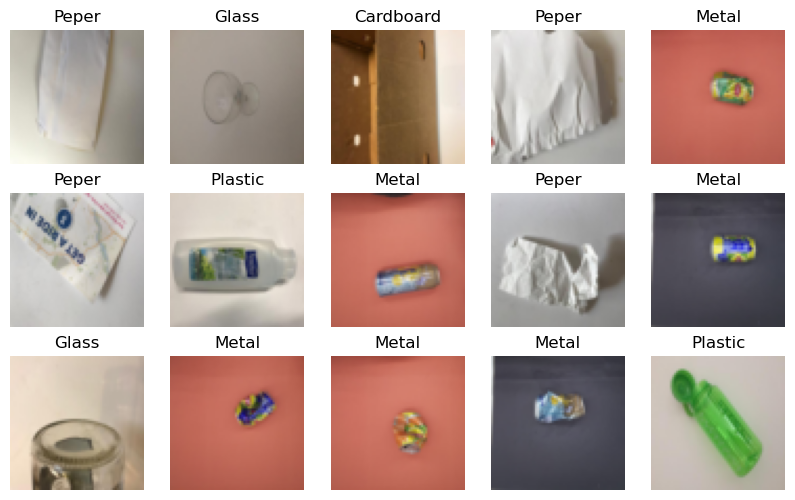

In [148]:
import random
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(train)-1)
        img, lab = train[ix]
        ax.imshow(img.reshape(3,64,64).permute(1,2,0))
        ax.set_title(classes[lab])
        ax.axis('off')
plt.show()

### Modelo pre entrenado

Vamos a utilizar el modelo ResNeXt50 en este laboratorio. La elección de este modelo se debe a sus capacidades y rendimiento probados en tareas de visión por computadora. ResNeXt50 es conocido por su profundidad y habilidad para aprender representaciones de alta calidad de datos visuales complejos.

Dado que nuestro conjunto de datos ya está normalizado y listo para el entrenamiento, la elección de ResNeXt50 nos brinda una base sólida para abordar nuestra tarea de clasificación de imágenes con confianza.

In [150]:
# Cargar el modelo preentrenado resnext50_32x4d
import timm

model = timm.create_model('resnest101e', pretrained=True)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNestBottleneck(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (

In [151]:
import torch.nn as nn

class Resnest101eCustom(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnext
    resnest = timm.create_model('resnest101e', pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnest = nn.Sequential(*list(resnest.children())[:-1])
    if freeze:
      for param in self.resnest.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = nn.Linear(2048, n_outputs)

  def forward(self, x):
    x = self.resnest(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnest.parameters():
        param.requires_grad=True

In [152]:
# hacemos la prueba de que nuestro modelo funciona correctamente
model_custom = Resnest101eCustom()
outputs = model_custom(torch.randn(64, 3, 64, 64))
outputs.shape

torch.Size([64, 5])

### Entreamiento

Hemos implementado la función `fit` para entrenar nuestro modelo, tal como mencionamos anteriormente. En este caso, estamos realizando un entrenamiento desde cero de nuestra red neuronal basada en el modelo ResNeXt50.

In [156]:
import numpy as np
import torch.optim as optim
from tqdm import tqdm

def fit(model, dataloader, epochs=5, lr_resnest=1e-4, lr_fc=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam([{'params': model.resnest.parameters(), 'lr': lr_resnest},{'params': model.fc.parameters(), 'lr': lr_fc}])
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y) 
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch 
                X, y = X.to(device), y.to(device) 
                y_hat = model(X) 
                loss = criterion(y_hat, y) 
                val_loss.append(loss.item()) 
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y) # type: ignore
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [157]:
# Entrenando con finetuning (Congelando y Descongelando), entrenamos solo la capa de salida (fc) y luego todas las capas
model = Resnest101eCustom(pretrained=True, freeze=True)

In [159]:
# entrenamos solo la capa de salida (fc) y luego todas las capas
fit(model, dataloader, epochs=7, lr_resnest=1e-4, lr_fc=0.001)
model.unfreeze()
fit(model, dataloader, epochs=5, lr_resnest=1e-4, lr_fc=0.001)
# acc 0.97365  val_acc 0.75308

val_loss 0.74157 val_acc 0.74284: 100%|██████████| 12/12 [00:03<00:00,  3.02it/s]


Epoch 1/7 loss 0.82047 val_loss 0.74157 acc 0.68106 val_acc 0.74284


val_loss 0.49577 val_acc 0.85060: 100%|██████████| 12/12 [00:03<00:00,  3.16it/s]


Epoch 2/7 loss 0.45871 val_loss 0.49577 acc 0.85388 val_acc 0.85060


val_loss 0.51511 val_acc 0.82914: 100%|██████████| 12/12 [00:03<00:00,  3.15it/s]


Epoch 3/7 loss 0.34112 val_loss 0.51511 acc 0.89337 val_acc 0.82914


val_loss 0.44882 val_acc 0.85241: 100%|██████████| 12/12 [00:03<00:00,  3.11it/s]


Epoch 4/7 loss 0.30679 val_loss 0.44882 acc 0.89725 val_acc 0.85241


val_loss 0.44465 val_acc 0.85971: 100%|██████████| 12/12 [00:03<00:00,  3.15it/s]


Epoch 5/7 loss 0.27223 val_loss 0.44465 acc 0.91581 val_acc 0.85971


val_loss 0.40654 val_acc 0.87013: 100%|██████████| 12/12 [00:03<00:00,  3.13it/s]


Epoch 6/7 loss 0.24546 val_loss 0.40654 acc 0.92434 val_acc 0.87013


val_loss 0.40746 val_acc 0.88276: 100%|██████████| 12/12 [00:03<00:00,  3.03it/s]


Epoch 7/7 loss 0.24352 val_loss 0.40746 acc 0.92188 val_acc 0.88276


val_loss 0.32801 val_acc 0.89510: 100%|██████████| 12/12 [00:03<00:00,  3.18it/s]


Epoch 1/5 loss 0.23030 val_loss 0.32801 acc 0.91780 val_acc 0.89510


val_loss 0.27311 val_acc 0.91553: 100%|██████████| 12/12 [00:03<00:00,  3.19it/s]


Epoch 2/5 loss 0.07240 val_loss 0.27311 acc 0.97633 val_acc 0.91553


val_loss 0.04352 val_acc 0.98256: 100%|██████████| 12/12 [00:03<00:00,  3.21it/s]


Epoch 3/5 loss 0.05346 val_loss 0.04352 acc 0.97992 val_acc 0.98256


val_loss 0.10171 val_acc 0.96148: 100%|██████████| 12/12 [00:03<00:00,  3.16it/s]


Epoch 4/5 loss 0.06481 val_loss 0.10171 acc 0.98248 val_acc 0.96148


val_loss 0.11969 val_acc 0.95627: 100%|██████████| 12/12 [00:03<00:00,  3.14it/s]

Epoch 5/5 loss 0.03770 val_loss 0.11969 acc 0.98627 val_acc 0.95627


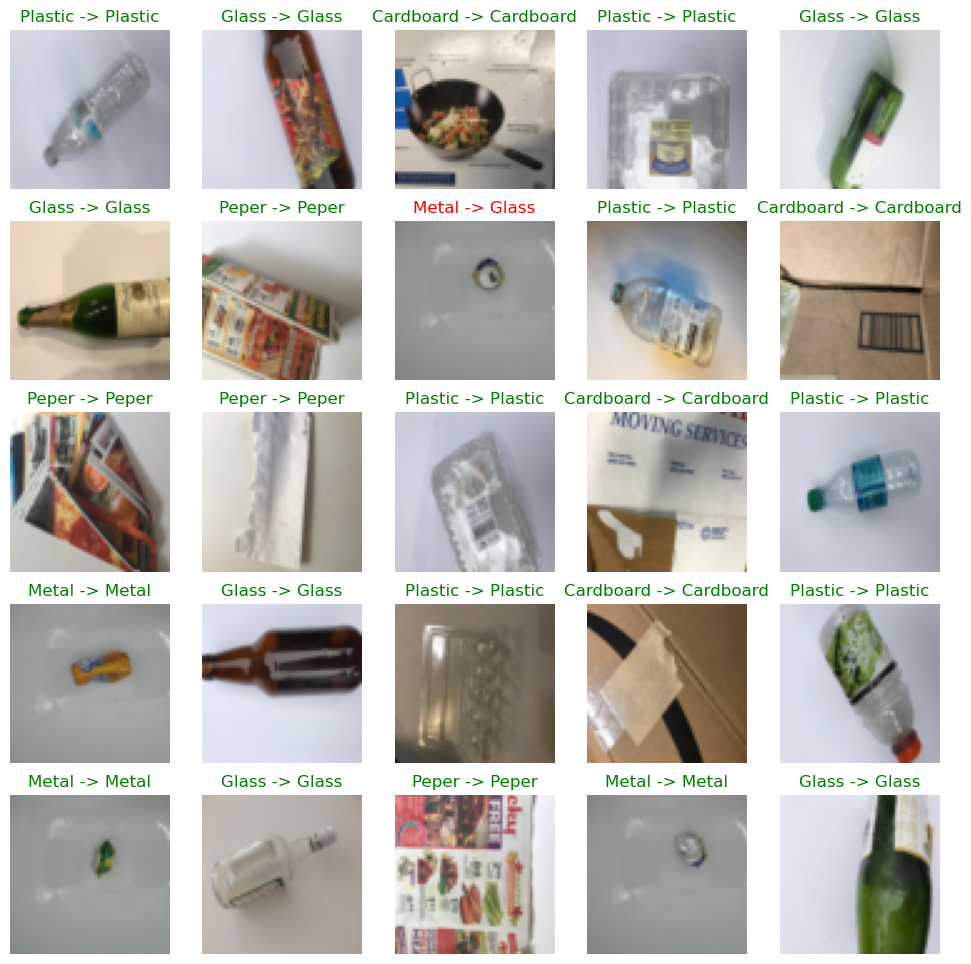

In [174]:
# hacemos la prueba mostrando algunas imagenes y ver si el modelo predice correctamente
model.eval()
fig, axs = plt.subplots(5,5, figsize=(12,12))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(test)-1)
        img, lab = test[ix]
        ax.imshow(img.reshape(3,64,64).permute(1,2,0))
        # pinta de verde el titulo si la predicción es correcta, de rojo si es incorrecta
        if torch.argmax(model(img.unsqueeze(0).to(device))).item() == lab:
            ax.set_title(f"{classes[lab]} -> {classes[torch.argmax(model(img.unsqueeze(0).to(device))).item()]}").set_color('green') # type: ignore
        else:
            ax.set_title(f"{classes[lab]} -> {classes[torch.argmax(model(img.unsqueeze(0).to(device))).item()]}").set_color('red') # type: ignore
        ax.axis('off')
plt.show()